<a href="https://colab.research.google.com/github/K-Hebel/WiDS_Chi/blob/master/Model_WiDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load Libraries

In [ ]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from xgboost import XGBClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics 

In [ ]:
#@title
! pip install -q kaggle
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"khebel","key":"11c0f35aedbce6808a3f45f82709accf"}'}

In [ ]:
#@title
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c 'widsdatathon2021'
! unzip TrainingWiDS2021.csv.zip -d train
! unzip UnlabeledWiDS2021.csv.zip -d train

  0% 0.00/90.0k [00:00<?, ?B/s]
100% 90.0k/90.0k [00:00<00:00, 33.3MB/s]
  0% 0.00/1.60M [00:00<?, ?B/s]
100% 1.60M/1.60M [00:00<00:00, 103MB/s]
 42% 9.00M/21.5M [00:00<00:00, 94.1MB/s]
100% 21.5M/21.5M [00:00<00:00, 105MB/s] 
  0% 0.00/28.2k [00:00<?, ?B/s]
100% 28.2k/28.2k [00:00<00:00, 27.4MB/s]
  0% 0.00/59.0 [00:00<?, ?B/s]
100% 59.0/59.0 [00:00<00:00, 55.2kB/s]
Archive:  TrainingWiDS2021.csv.zip
  inflating: train/TrainingWiDS2021.csv  
Archive:  UnlabeledWiDS2021.csv.zip
  inflating: train/UnlabeledWiDS2021.csv  


In [125]:
df=pd.read_csv("train/TrainingWiDS2021.csv")

#Load DataFile 'final_sample.csv' - A 50,000 record sample of orginal training dataset (Cleaned Based on EDA comments -df_A)

In [188]:
df_A=sample=df.groupby('diabetes_mellitus', group_keys=False).apply(lambda x: x.sample(25000))

In [189]:
list(df_A.columns)

['Unnamed: 0',
 'encounter_id',
 'hospital_id',
 'age',
 'bmi',
 'elective_surgery',
 'ethnicity',
 'gender',
 'height',
 'hospital_admit_source',
 'icu_admit_source',
 'icu_id',
 'icu_stay_type',
 'icu_type',
 'pre_icu_los_days',
 'readmission_status',
 'weight',
 'albumin_apache',
 'apache_2_diagnosis',
 'apache_3j_diagnosis',
 'apache_post_operative',
 'arf_apache',
 'bilirubin_apache',
 'bun_apache',
 'creatinine_apache',
 'fio2_apache',
 'gcs_eyes_apache',
 'gcs_motor_apache',
 'gcs_unable_apache',
 'gcs_verbal_apache',
 'glucose_apache',
 'heart_rate_apache',
 'hematocrit_apache',
 'intubated_apache',
 'map_apache',
 'paco2_apache',
 'paco2_for_ph_apache',
 'pao2_apache',
 'ph_apache',
 'resprate_apache',
 'sodium_apache',
 'temp_apache',
 'urineoutput_apache',
 'ventilated_apache',
 'wbc_apache',
 'd1_diasbp_invasive_max',
 'd1_diasbp_invasive_min',
 'd1_diasbp_max',
 'd1_diasbp_min',
 'd1_diasbp_noninvasive_max',
 'd1_diasbp_noninvasive_min',
 'd1_heartrate_max',
 'd1_heartrate

##Drop Demographic data that EDA show had low correlation

In [190]:
df_A=df_A.drop(['Unnamed: 0',
 'encounter_id',
 'hospital_id',
 'bmi',
 'elective_surgery',
 'ethnicity',
 'gender',
 'hospital_admit_source',
 'icu_admit_source',
 'icu_id',
 'icu_stay_type',
 'icu_type',
 'pre_icu_los_days',
 'readmission_status'], axis=1)
df_A.describe()

,age,height,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,...,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
count,48372.000000,49308.000000,48684.000000,20323.000000,49487.000000,49785.000000,50000.000000,50000.000000,18521.000000,40840.000000,41025.000000,11889.000000,49282.000000,49282.000000,49807.000000,49282.000000,45782.000000,49885.000000,39875.000000,50000.00000,49867.000000,11889.000000,11889.000000,11889.000000,11889.000000,49691.000000,41181.000000,47568.000000,24953.000000,50000.000000,38915.000000,13449.000000,13449.000000,49905.000000,49905.000000,49331.000000,49331.000000,49904.000000,49904.000000,13532.000000,...,10690.000000,10690.000000,10634.000000,10634.000000,18711.000000,18711.000000,4696.000000,4696.00000,9560.000000,9560.000000,11989.000000,11989.000000,11565.000000,11565.000000,9459.000000,9459.000000,17883.000000,17883.000000,17738.000000,17738.000000,18065.000000,18065.000000,14436.000000,14436.000000,8876.000000,8876.000000,8811.000000,8811.000000,8978.000000,8978.000000,6606.000000,6606.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000
mean,62.963305,169.503526,86.433156,2.872927,185.506759,561.679474,0.202960,0.040780,1.129725,27.706565,1.610061,0.593871,3.502861,5.503916,0.010541,4.047441,181.872205,99.659056,32.731378,0.15690,87.198788,42.190058,42.190058,129.473724,7.350755,25.121911,137.796693,36.414170,1813.298203,0.335280,12.243101,78.274890,46.237490,88.437251,49.365655,88.613793,49.424459,103.002705,70.701347,114.352793,...,11.098971,10.976099,33.471591,33.097122,1.596378,1.482422,3.007268,2.95487,195.079079,194.333891,4.229299,4.185328,138.046623,137.757527,13.467302,13.418191,45.346021,38.522312,7.386580,7.320260,162.668363,100.946766,285.836729,221.704100,44.558539,43.340008,7.335257,7.325236,160.519055,142.871940,244.003066,235.658410,0.000740,0.017240,0.014360,0.026340,0.007440,0.004340,0.01966,0.500000
std,15.966279,10.856217,25.934313,0.673578,86.338485,460.016644,0.402207,0.197782,2.128164,21.620377,1.652210,0.263859,0.924781,1.248101,0.102126,1.527991,103.316270,30.380747,6.772862,0.36371,42.194799,12.381911,12.381911,83.011056,0.100028,15.045368,5.329956,0.859425,1465.819993,0.472093,6.900736,21.383069,12.624518,20.524260,13.355644,20.509613,13.380068,21.773232,16.999668,49.888351,...,2.331912,2.363648,6.765574,6.923308,0.965330,0.753996,2.839468,2.79628,91.678957,91.885607,0.782363,0.773822,5.684848,5.619405,6.914300,6.905409,14.586547,11.068111,0.087116,0.113111,104.848484,59.319164,130.144171,118.025446,14.581302,14.077359,0.107986,0.110295,110.126143,97.542337,131.171456,127.480853,0.027193,0.130166,0.118971,0.160146,0.085935,0.065736,0.13883,0.500005
min,0.000000,137.200000,38.600000,1.200000,101.000000,0.020000,0.000000,0.0000

##Calculate BMI and replace 'height' and 'weight' columns

In [191]:
df_A['bmi']= df_A['weight']/((df_A['height']/100)**2)

In [192]:
df_A_2=df_A.drop(['height', 'weight'], axis = 1)

In [193]:
df_A_2.head()

,age,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,...,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus,bmi
66656,50.0,NaN,107.0,202.01,0,0,NaN,NaN,NaN,NaN,4.0,6.0,0.0,5.0,NaN,118.0,NaN,0,78.0,NaN,NaN,NaN,NaN,27.0,NaN,36.6,1722.4704,0,NaN,NaN,NaN,75.0,57.0,75.0,57.0,112.0,108.0,NaN,NaN,90.0,...,NaN,NaN,NaN,1.3,1.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,24.921875
34721,69.0,NaN,117.0,106.01,0,0,NaN,NaN,NaN,NaN,4.0,6.0,0.0,4.0,134.0,140.0,NaN,0,68.0,NaN,NaN,NaN,NaN,39.0,NaN,36.8,NaN,0,NaN,NaN,NaN,72.0,62.0,72.0,62.0,139.0,127.0,NaN,NaN,80.0,...,NaN,NaN,NaN,1.4,1.4,2.2,2.2,NaN,NaN,NaN,NaN,129.0,129.0,NaN,NaN,36.5,36.5,7.320,7.320,103.0,103.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,34.277511
101234,68.0,1.8,NaN,0.25,0,0,2.1,11.0,0.49,0.4,4.0,6.0,0.0,5.0,190.0,129.0,51.2,1,174.0,29.8,29.8,150.0,7.405,39.0,140.0,36.0,NaN,1,23.7,75.0,49.0,95.0,37.0,95.0,37.0,84.0,58.0,101.0,69.0,69.0,...,5.0,51.2,51.2,1.2,1.2,NaN,NaN,119.0,119.0,4.2,4.2,140.0,140.0,23.7,23.7,29.8,24.7,7.413,7.405,459.0,150.0,459.0,375.0,24.7,24.7,7.413,7.413,459.0,459.0,459.0,459.0,0,0,0,0,0,0,0,0,31.191118
52176,51.0,NaN,120.0,407.01,0,0,NaN,NaN,NaN,NaN,4.0,6.0,0.0,5.0,NaN,134.0,37.3,0,62.0,NaN,NaN,NaN,NaN,5.0,NaN,36.6,3435.2640,0,NaN,NaN,NaN,75.0,58.0,75.0,58.0,132.0,82.0,NaN,NaN,92.0,...,NaN,NaN,NaN,NaN,NaN,1.3,1.3,NaN,NaN,3.2,3.2,136.0,136.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,24.946795
114705,55.0,NaN,301.0,403.01,0,0,NaN,10.0,0.94,0.5,1.0,4.0,0.0,1.0,62.0,99.0,42.3,0,150.0,43.0,43.0,111.0,7.340,4.0,140.0,37.4,1735.8624,1,11.7,68.0,51.0,81.0,58.0,81.0,58.0,95.0,59.0,93.0,64.0,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.0,43.0,7.340,7.300,174.0,111.0,222.0,174.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,25.915974


##Proportion of Missing Data in df_A by Feature Column and Count of Available data by Feature Column

In [194]:
missing_data= pd.DataFrame(df_A_2.isna().sum()/df_A_2['diabetes_mellitus'].count())
missing_data['Available']= df_A_2.notna().sum()
missing_data.sort_values(0,ascending=False)

,0,Available
h1_bilirubin_max,0.91906,4047
h1_bilirubin_min,0.91906,4047
h1_albumin_min,0.91138,4431
h1_albumin_max,0.91138,4431
h1_lactate_min,0.90608,4696
...,...,...
leukemia,0.00000,50000
lymphoma,0.00000,50000
solid_tumor_with_metastasis,0.00000,50000
diabetes_mellitus,0.00000,50000


## Drop Features were total available data is less than 20% of data set

In [195]:
features_under_20per =[]

for col in list(df_A_2.columns):
  if df_A_2[col].count()/df_A_2.count()[-1]< .2:
    features_under_20per.append(col)

In [196]:
df_A_3 = df_A_2.drop(features_under_20per, axis=1)

In [197]:
df_A_3.describe()

,age,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,...,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus,bmi
count,48372.000000,20323.000000,49487.000000,49785.000000,50000.000000,50000.000000,18521.000000,40840.000000,41025.000000,11889.000000,49282.000000,49282.000000,49807.000000,49282.000000,45782.000000,49885.000000,39875.000000,50000.00000,49867.000000,11889.000000,11889.000000,11889.000000,11889.000000,49691.000000,41181.000000,47568.000000,24953.000000,50000.000000,38915.000000,13449.000000,13449.000000,49905.000000,49905.000000,49331.000000,49331.000000,49904.000000,49904.000000,13532.000000,13532.000000,49895.000000,...,45701.000000,45421.000000,45421.000000,43535.000000,43535.000000,10269.000000,10269.000000,9932.00000,9932.000000,10345.00000,10345.000000,23751.000000,23751.000000,10690.000000,10690.000000,10634.000000,10634.000000,18711.000000,18711.000000,11989.000000,11989.000000,11565.000000,11565.000000,17883.000000,17883.000000,17738.000000,17738.000000,18065.000000,18065.000000,14436.000000,14436.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,48324.000000
mean,62.963305,2.872927,185.506759,561.679474,0.202960,0.040780,1.129725,27.706565,1.610061,0.593871,3.502861,5.503916,0.010541,4.047441,181.872205,99.659056,32.731378,0.15690,87.198788,42.190058,42.190058,129.473724,7.350755,25.121911,137.796693,36.414170,1813.298203,0.335280,12.243101,78.274890,46.237490,88.437251,49.365655,88.613793,49.424459,103.002705,70.701347,114.352793,61.643807,104.622307,...,3.939682,139.103175,137.526226,12.590897,11.358260,27.319535,27.295092,8.30448,8.300133,1.63209,1.630127,187.227870,176.523852,11.098971,10.976099,33.471591,33.097122,1.596378,1.482422,4.229299,4.185328,138.046623,137.757527,45.346021,38.522312,7.386580,7.320260,162.668363,100.946766,285.836729,221.704100,0.000740,0.017240,0.014360,0.026340,0.007440,0.004340,0.01966,0.500000,30.022812
std,15.966279,0.673578,86.338485,460.016644,0.402207,0.197782,2.128164,21.620377,1.652210,0.263859,0.924781,1.248101,0.102126,1.527991,103.316270,30.380747,6.772862,0.36371,42.194799,12.381911,12.381911,83.011056,0.100028,15.045368,5.329956,0.859425,1465.819993,0.472093,6.900736,21.383069,12.624518,20.524260,13.355644,20.509613,13.380068,21.773232,16.999668,49.888351,17.644506,21.342339,...,0.594772,4.842530,4.938129,6.752592,5.908094,22.200462,22.183718,0.87936,0.888365,1.67462,1.672225,107.461971,100.948560,2.331912,2.363648,6.765574,6.923308,0.965330,0.753996,0.782363,0.773822,5.684848,5.619405,14.586547,11.068111,0.087116,0.113111,104.848484,59.319164,130.144171,118.025446,0.027193,0.130166,0.118971,0.160146,0.085935,0.065736,0.13883,0.500005,8.558031
min,0.000000,1.200000,101.000000,0.020000,0.000000,0.000000,0.100000,4.000000,0.300000,0.210000,1.000000,1.000000,0.000

##Set Features and Target (df_A) and Train_Test_split

In [198]:
y_a=df_A_3['diabetes_mellitus']
X_a=df_A_3.drop(['diabetes_mellitus'], axis=1)

X_a_train, X_a_test,y_a_train, y_a_test =train_test_split(X_a,y_a, random_state=40)

In [199]:
y_a.shape, X_a.shape

((50000,), (50000, 145))

In [200]:
test_col_A=list(X_a_train.columns)
test_col_A

['age',
 'albumin_apache',
 'apache_2_diagnosis',
 'apache_3j_diagnosis',
 'apache_post_operative',
 'arf_apache',
 'bilirubin_apache',
 'bun_apache',
 'creatinine_apache',
 'fio2_apache',
 'gcs_eyes_apache',
 'gcs_motor_apache',
 'gcs_unable_apache',
 'gcs_verbal_apache',
 'glucose_apache',
 'heart_rate_apache',
 'hematocrit_apache',
 'intubated_apache',
 'map_apache',
 'paco2_apache',
 'paco2_for_ph_apache',
 'pao2_apache',
 'ph_apache',
 'resprate_apache',
 'sodium_apache',
 'temp_apache',
 'urineoutput_apache',
 'ventilated_apache',
 'wbc_apache',
 'd1_diasbp_invasive_max',
 'd1_diasbp_invasive_min',
 'd1_diasbp_max',
 'd1_diasbp_min',
 'd1_diasbp_noninvasive_max',
 'd1_diasbp_noninvasive_min',
 'd1_heartrate_max',
 'd1_heartrate_min',
 'd1_mbp_invasive_max',
 'd1_mbp_invasive_min',
 'd1_mbp_max',
 'd1_mbp_min',
 'd1_mbp_noninvasive_max',
 'd1_mbp_noninvasive_min',
 'd1_resprate_max',
 'd1_resprate_min',
 'd1_spo2_max',
 'd1_spo2_min',
 'd1_sysbp_invasive_max',
 'd1_sysbp_invasive_

In [201]:
y_a_train.shape, X_a_train.shape

((37500,), (37500, 145))

#Load Original DataFile of 130,157 records (Clean Based on Prop of Available Data - df_B)

In [ ]:
#@title
df_B=pd.read_csv("train/TrainingWiDS2021.csv")



##Proportion of Missing Data in df_B by Feature Column and Count of Available data by Feature Column

In [ ]:
missing_data_B= pd.DataFrame(df_B.isna().sum()/df_B['diabetes_mellitus'].count())
missing_data_B['Available']= df_B.notna().sum()
missing_data_B.sort_values(0,ascending=False)

,0,Available
h1_bilirubin_max,0.920896,10296
h1_bilirubin_min,0.920896,10296
h1_albumin_max,0.914319,11152
h1_albumin_min,0.914319,11152
h1_lactate_min,0.910185,11690
...,...,...
icu_stay_type,0.000000,130157
icu_id,0.000000,130157
elective_surgery,0.000000,130157
hospital_id,0.000000,130157


##Drop Columns with missing data >=70% from df_B

In [ ]:
col_drop=missing_data_B[missing_data_B[0]>= 0.70].sort_values(by=0, ascending=False)
df_B= df_B.drop(list(col_drop.index), axis=1) #[0].sort_values
df_B.shape

(130157, 126)

##Create Stratified Sample of df_B dataset to balance target variable value counts for sample size of 56,302 (included all positive diabetes_mellitus from original dataset)

In [ ]:
df_B['diabetes_mellitus'].value_counts()

0    102006
1     28151
Name: diabetes_mellitus, dtype: int64

In [ ]:
sample_df_B=df_B.groupby('diabetes_mellitus', group_keys=False).apply(lambda x: x.sample(28151))
sample_df_B.describe()

,Unnamed: 0,encounter_id,hospital_id,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,...,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_glucose_max,h1_glucose_min,h1_inr_max,h1_inr_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
count,56302.000000,56302.000000,56302.000000,54472.000000,54386.000000,56302.000000,55494.000000,56302.000000,56302.000000,56302.0,54818.000000,22958.000000,55691.000000,56025.000000,56302.000000,56302.000000,20901.000000,45911.000000,46134.000000,55482.000000,55482.000000,56070.000000,55482.000000,51450.000000,56187.000000,44853.000000,56302.000000,56152.000000,55949.000000,46312.000000,53522.000000,28214.000000,56302.000000,43722.000000,56190.000000,56190.000000,55586.000000,55586.000000,56203.000000,56203.000000,...,49653.000000,49653.000000,51028.000000,51028.000000,53597.000000,53597.000000,48015.000000,48015.000000,49382.000000,49382.000000,49619.000000,49619.000000,21104.000000,21104.000000,48426.000000,48426.000000,51370.000000,51370.000000,51035.000000,51035.000000,48871.000000,48871.000000,26633.000000,26633.000000,21104.000000,21104.000000,20249.000000,20249.000000,20090.000000,20090.000000,20469.000000,20469.000000,56302.000000,56302.000000,56302.000000,56302.000000,56302.000000,56302.000000,56302.000000,56302.000000
mean,64484.339650,212710.490107,106.320077,62.954178,30.089914,0.187897,169.586084,658.226049,0.876045,0.0,86.499470,2.870947,185.886122,562.235747,0.202959,0.040656,1.145172,27.796522,1.613398,3.501947,5.502848,0.010487,4.044609,181.961458,99.504209,32.724375,0.157135,87.263902,25.075844,137.811708,36.415434,1815.297139,0.336933,12.216025,88.296352,49.379427,88.453891,49.440381,102.955074,70.555629,...,8.401404,8.176434,1.626973,1.480623,197.773364,117.924623,24.432119,23.023501,11.338542,10.797319,34.260461,32.685121,1.599179,1.483163,206.561682,195.747288,4.298890,3.944602,139.112615,137.545567,12.563138,11.335309,187.408106,176.714189,1.599179,1.483163,45.333439,38.609551,7.386275,7.320536,163.241823,101.746546,0.000817,0.017335,0.014120,0.025914,0.007424,0.004316,0.020319,0.500000
std,37340.807305,38148.871604,63.879414,16.072909,8.649497,0.390634,10.833280,302.392257,2.507445,0.0,25.887468,0.677074,86.449028,460.310703,0.402206,0.197493,2.213268,21.645589,1.651009,0.927873,1.249993,0.101868,1.531584,103.471087,30.458204,6.731138,0.363931,42.157962,15.094207,5.297658,0.859839,1482.031428,0.472666,6.902168,20.380330,13.304645,20.364836,13.332743,21.804234,17.078239,...,0.739053,0.788592,1.635321,1.446892,98.928557,42.701657,4.450332,5.246155,2.134552,2.303874,6.162850,6.711352,0.976071,0.761736,89.357600,87.745938,0.691414,0.595507,4.825295,4.909020,6.745437,5.880289,108.036430,101.524634,0.976071,0.761736,14.467253,11.097280,0.086348,0.111841,105.796790,60.622601,0.028572,0.130518,0.117988,0.158880,0.085844,0.065555,0.141090,0.500004
min,1.000000,147001.000000,1.000000,0.000000,14.844926,0.000000,137.200000,82.000000,-0.211806,0.0,38.600000,1.200000,101.000000,0.010000,0.000000,0.000000,0.100000,

In [ ]:
sample_df_B['diabetes_mellitus'].value_counts()

1    28151
0    28151
Name: diabetes_mellitus, dtype: int64

##Drop Features Not Associated with Patient Vitals

In [ ]:
drop_cols2 =['Unnamed: 0',
 'encounter_id',
 'hospital_id',
 'elective_surgery',
 'hospital_admit_source',
 'icu_admit_source',
 'icu_id',
 'icu_stay_type',
 'icu_type',
 'pre_icu_los_days',
 'readmission_status',
 ]

sample_df_B2=sample_df_B.drop(drop_cols2, axis=1)
sample_df_B2.shape

(56302, 115)

##Encode Categorical Data in sample_df_B2 (Sample set of df_B)

In [ ]:
sample_df_B2.select_dtypes(include=['object']).columns

Index(['ethnicity', 'gender'], dtype='object')

In [ ]:
demo_cat=pd.get_dummies(sample_df_B2[['gender','ethnicity']])
sample_df_B3 = sample_df_B2.join(demo_cat)
sample_df_B3=sample_df_B3.drop(['gender','ethnicity'], axis=1)
sample_df_B3.shape

(56302, 121)

##Normalize All Numerical Data in sample_df  using a max min scaler
lambda x: (x - x.min()) / (x.max() - x.min()) (sample_df_B4)

In [ ]:
sample_df_B4 = sample_df_B3.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
sample_df_B4.describe()

,age,bmi,height,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,...,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_glucose_max,h1_glucose_min,h1_inr_max,h1_inr_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus,gender_F,gender_M,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown
count,54472.000000,54386.000000,55494.000000,54818.000000,22958.000000,55691.000000,56025.000000,56302.000000,56302.000000,20901.000000,45911.000000,46134.000000,55482.000000,55482.000000,56070.000000,55482.000000,51450.000000,56187.000000,44853.000000,56302.000000,56152.000000,55949.000000,46312.000000,53522.000000,28214.000000,56302.000000,43722.000000,56190.000000,56190.000000,55586.000000,55586.000000,56203.000000,56203.000000,56182.000000,56182.000000,55314.000000,55314.000000,56006.000000,56006.000000,56089.000000,...,49382.000000,49382.000000,49619.000000,49619.000000,21104.000000,21104.000000,48426.000000,48426.000000,51370.000000,51370.000000,51035.000000,51035.000000,48871.000000,48871.000000,26633.000000,26633.000000,21104.000000,21104.000000,20249.000000,20249.000000,20090.000000,20090.000000,20469.000000,20469.000000,56302.000000,56302.000000,56302.000000,56302.000000,56302.000000,56302.000000,56302.000000,56302.000000,56302.000000,56302.000000,56302.000000,56302.000000,56302.000000,56302.000000,56302.000000,56302.000000
mean,0.707350,0.287804,0.554651,0.324962,0.491455,0.410078,0.255436,0.202959,0.040656,0.017391,0.193468,0.120717,0.833982,0.900570,0.010487,0.761152,0.255425,0.469623,0.469442,0.157135,0.295399,0.376354,0.507603,0.567820,0.208256,0.336933,0.252027,0.355432,0.472460,0.356755,0.473252,0.377774,0.440973,0.358756,0.468351,0.367114,0.468816,0.189566,0.190785,0.992982,...,0.436398,0.482221,0.445674,0.489237,0.101981,0.111567,0.321795,0.328813,0.356879,0.454295,0.460360,0.570710,0.253189,0.260896,0.201885,0.214513,0.101981,0.111567,0.290858,0.333881,0.586854,0.644650,0.247560,0.175215,0.000817,0.017335,0.014120,0.025914,0.007424,0.004316,0.020319,0.500000,0.454211,0.545345,0.115786,0.018028,0.755266,0.040727,0.008366,0.051188
std,0.180594,0.163290,0.185533,0.175627,0.199139,0.417628,0.209133,0.402206,0.197493,0.036826,0.175980,0.151747,0.309291,0.249999,0.101868,0.382896,0.184869,0.205799,0.191226,0.363931,0.263487,0.269539,0.129211,0.113137,0.170023,0.472666,0.153723,0.171263,0.172788,0.171133,0.173153,0.183229,0.106739,0.170609,0.172028,0.173483,0.172294,0.135919,0.076561,0.016847,...,0.205245,0.202094,0.198162,0.197975,0.142367,0.145731,0.160139,0.162824,0.164622,0.175149,0.137866,0.136362,0.150299,0.147015,0.169857,0.161663,0.142367,0.145731,0.156234,0.156273,0.152634,0.167462,0.210807,0.144034,0.028572,0.130518,0.117988,0.158880,0.085844,0.065555,0.141090,0.500004,0.497903,0.497944,0.319971,0.133053,0.429933,0.197658,0.091081,0.220383
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

In [ ]:
sample_df_B4.columns

Index(['age', 'bmi', 'height', 'weight', 'albumin_apache',
       'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_post_operative',
       'arf_apache', 'bilirubin_apache',
       ...
       'solid_tumor_with_metastasis', 'diabetes_mellitus', 'gender_F',
       'gender_M', 'ethnicity_African American', 'ethnicity_Asian',
       'ethnicity_Caucasian', 'ethnicity_Hispanic',
       'ethnicity_Native American', 'ethnicity_Other/Unknown'],
      dtype='object', length=121)

##Set Features and Target (sample of df_B) & Training, Test Split

In [ ]:
y_b=sample_df_B3['diabetes_mellitus'] #not normalized
X_b=sample_df_B3.drop(['diabetes_mellitus','aids',
 'cirrhosis',
 'hepatic_failure',
 'immunosuppression',
 'leukemia',
 'lymphoma',
 'solid_tumor_with_metastasis',
 'gender_F',
 'gender_M',
 'ethnicity_African American',
 'ethnicity_Asian',
 'ethnicity_Caucasian',
 'ethnicity_Hispanic',
 'ethnicity_Native American',
 'ethnicity_Other/Unknown'], axis=1)

X_b_train, X_b_test, y_b_train,y_b_test =train_test_split(X_b,y_b, random_state=40)

In [ ]:
test_col_B=list(X_b.columns)
test_col_B

['age',
 'bmi',
 'height',
 'weight',
 'albumin_apache',
 'apache_2_diagnosis',
 'apache_3j_diagnosis',
 'apache_post_operative',
 'arf_apache',
 'bilirubin_apache',
 'bun_apache',
 'creatinine_apache',
 'gcs_eyes_apache',
 'gcs_motor_apache',
 'gcs_unable_apache',
 'gcs_verbal_apache',
 'glucose_apache',
 'heart_rate_apache',
 'hematocrit_apache',
 'intubated_apache',
 'map_apache',
 'resprate_apache',
 'sodium_apache',
 'temp_apache',
 'urineoutput_apache',
 'ventilated_apache',
 'wbc_apache',
 'd1_diasbp_max',
 'd1_diasbp_min',
 'd1_diasbp_noninvasive_max',
 'd1_diasbp_noninvasive_min',
 'd1_heartrate_max',
 'd1_heartrate_min',
 'd1_mbp_max',
 'd1_mbp_min',
 'd1_mbp_noninvasive_max',
 'd1_mbp_noninvasive_min',
 'd1_resprate_max',
 'd1_resprate_min',
 'd1_spo2_max',
 'd1_spo2_min',
 'd1_sysbp_max',
 'd1_sysbp_min',
 'd1_sysbp_noninvasive_max',
 'd1_sysbp_noninvasive_min',
 'd1_temp_max',
 'd1_temp_min',
 'h1_diasbp_max',
 'h1_diasbp_min',
 'h1_diasbp_noninvasive_max',
 'h1_diasbp_non

In [ ]:
y_b_train.shape, X_b_train.shape

((42226,), (42226, 105))

In [ ]:
y_b_test.shape, X_b_test.shape

((14076,), (14076, 105))

#Create Training and Predictive Models For df_A (Sample set of 50,000)

In [215]:
model_1_A= XGBClassifier(booster='dart', n_estimators=300) #used to manage datasets with missing values
model_2_A= Pipeline(([('imputer', KNNImputer()), ('clf', RandomForestClassifier())]))

## XGBClassifier Model 1 - df_A

In [216]:
model_1_A.fit(X_a_train,y_a_train)


XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [217]:
model_1_A.score(X_a_test,y_a_test)

0.77832

##Hyper Tuning XGBClassifier with RandomGridSV

In [208]:
from sklearn.model_selection import RandomizedSearchCV

##RandomForestClassifier Model 2- df_A

In [ ]:
model_2_A.fit(X_a_train,y_a_train)

Pipeline(memory=None,
         steps=[('imputer',
                 KNNImputer(add_indicator=False, copy=True,
                            metric='nan_euclidean', missing_values=nan,
                            n_neighbors=5, weights='uniform')),
                ('clf',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=No

In [ ]:
sorted_idx = model_2_A.feature_importances_.argsort()
plt.barh(boston.feature_names[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [ ]:
model_2_A.score(X_a_test,y_a_test)

0.73952

#Create Training and Predictive Models For df_B (Sample set of 56,302)

In [ ]:
model_1_B= XGBClassifier() #used to manage datasets with missing values
model_2_B= Pipeline(([('imputer', KNNImputer()), ('clf', RandomForestClassifier())]))


## XGBClassifier Model 1 - df_B

In [ ]:
model_1_B.fit(X_b_train,y_b_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:

model_1_B.score(X_b_test,y_b_test)

0.7660556976413754

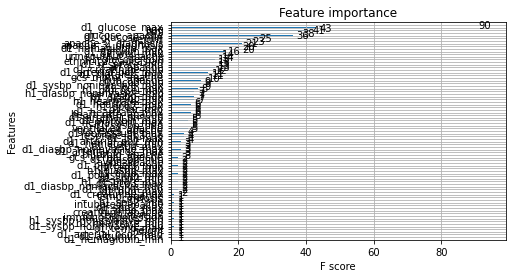

In [ ]:
from xgboost import plot_importance
plot_importance(model_1_B)
plt.show()

In [ ]:
model_1_B.feature_importances_

array([0.02911969, 0.03792285, 0.00226462, 0.01466383, 0.        ,
       0.01069222, 0.01103346, 0.        , 0.02779733, 0.00974493,
       0.01084354, 0.00524127, 0.02104625, 0.01482494, 0.        ,
       0.01890271, 0.01408151, 0.02330216, 0.        , 0.00287238,
       0.        , 0.00494135, 0.        , 0.00416023, 0.00853133,
       0.01896569, 0.00322858, 0.        , 0.00424145, 0.00501557,
       0.0031312 , 0.01643657, 0.00561249, 0.00279737, 0.        ,
       0.        , 0.        , 0.        , 0.00642281, 0.00537612,
       0.00390618, 0.0070102 , 0.00668568, 0.00770778, 0.0104466 ,
       0.01185764, 0.00688498, 0.00518605, 0.00667772, 0.        ,
       0.00694751, 0.00805725, 0.00301368, 0.00314149, 0.        ,
       0.        , 0.        , 0.        , 0.01141928, 0.00463454,
       0.00378636, 0.00826856, 0.        , 0.        , 0.00876706,
       0.        , 0.        , 0.00362904, 0.        , 0.01050703,
       0.00326145, 0.02300063, 0.0167039 , 0.        , 0.01122

In [ ]:
# make predictions for test data and evaluate
y__1_B_pred = model.predict(X_b_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_b_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

##RandomForestRegressor 2 - df_B

In [ ]:
model_2_B.fit(X_b_train,y_b_train)

Pipeline(memory=None,
         steps=[('imputer',
                 KNNImputer(add_indicator=False, copy=True,
                            metric='nan_euclidean', missing_values=nan,
                            n_neighbors=5, weights='uniform')),
                ('clf',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=No

In [ ]:
from  sklearn.inspection import permutation_importance

In [ ]:
model_2_B.steps[1]

('clf',
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False))

##Feature Importance for RandomForestClassifier

In [ ]:
model_2_B[1].feature_importances_

array([1.61082712e-02, 2.39708028e-02, 7.72905739e-03, 2.10595024e-02,
       7.64581147e-03, 9.19861322e-03, 9.12391181e-03, 7.28293735e-04,
       1.79185406e-03, 7.60591053e-03, 1.17344339e-02, 1.17680573e-02,
       2.20923591e-03, 2.28332840e-03, 3.33190721e-04, 2.34604737e-03,
       5.87355994e-02, 9.01308811e-03, 8.47296997e-03, 9.62016598e-04,
       7.22338355e-03, 7.20193803e-03, 6.75714000e-03, 6.52503111e-03,
       8.71222654e-03, 1.36675717e-03, 9.08324189e-03, 6.96167145e-03,
       6.88551987e-03, 7.05888300e-03, 6.91135770e-03, 8.81320426e-03,
       8.15474809e-03, 6.57338207e-03, 6.48977982e-03, 6.75401844e-03,
       6.48075116e-03, 7.16034014e-03, 6.50543218e-03, 2.57039821e-03,
       6.58981389e-03, 8.25002841e-03, 7.71476453e-03, 8.24533653e-03,
       7.46753281e-03, 6.78826765e-03, 6.47148485e-03, 7.39696324e-03,
       7.40017041e-03, 6.97372060e-03, 7.26593627e-03, 8.53623632e-03,
       7.64294736e-03, 6.61707598e-03, 6.25678268e-03, 6.71204905e-03,
      

In [ ]:
model_2_B.score(X_b_test,y_b_test)

0.7505683432793407

###Results reflect that XGBClassifier and RandomForest Classifier are the strongest predictive models

##Parameter Tweeking

In [ ]:
##Parameter Tweeking

#Using Unlabled Data

In [ ]:
test_df_A=pd.read_csv('train/UnlabeledWiDS2021.csv')
test_df_B = test_df_A

In [ ]:
test_df.shape

(10234, 181)

Predictions based on model_A XBBClassifier

In [218]:
test_df_A['diabetes_mellitus']=model_1_A.predict(test_df_A[test_col_A])
submit_A = test_df_A[['encounter_id','diabetes_mellitus']]
submit_A

,encounter_id,diabetes_mellitus
0,144740,0
1,141990,0
2,142038,1
3,138628,0
4,141682,1
...,...,...
10229,143750,0
10230,143813,0
10231,137126,0
10232,135652,0


In [219]:
test_df_A['diabetes_mellitus'].sum()

3568

In [221]:
submit_A.to_csv('Boost_Class_A.csv',index=False)

#Predictive Scores with Datasets A & B that are NOT normalized

In [ ]:
test_df_B['diabetes_mellitus']=model_1_B.predict(test_df_B[test_col_B])
submit_B = test_df_B[['encounter_id','diabetes_mellitus']]
submit_B

,encounter_id,diabetes_mellitus
0,144740,0
1,141990,0
2,142038,0
3,138628,0
4,141682,1
...,...,...
10229,143750,0
10230,143813,0
10231,137126,0
10232,135652,0


In [ ]:
test_df_B['diabetes_mellitus'].sum()

3652

In [ ]:
submit_B.to_csv('Boost_Class_B.csv',index=False)